# CNNLorenzMie Prediction

This notebook provides a template for post-processing video predictions. We start by setting the correct path and importing relevant CNNLorenzMie objects

In [1]:
import os
import numpy as np
import cv2, json
import matplotlib.pyplot as plt
from time import time
import pandas as pd

import sys

# sys.path.append('/home/group/python/')
sys.path.append('/home/jackie/Desktop/')


# ############ Uncomment for 'new' (frame-oriented) CNNLorenzMie ################
# cnn_path = '/home/jackie/Documents/Github/cleanup'
# if cnn_path not in sys.path: sys.path.append(cnn_path)
    
# plmie_path = '/home/jackie/Documents/Github/cleanup/CNNLorenzTest'
# if plmie_path not in sys.path: sys.path.append(plmie_path)

from pylorenzmie.analysis import Frame, Video

from CNNLorenzMie.Localizer import Localizer
from CNNLorenzMie.Estimator import Estimator
from CNNLorenzMie.crop_feature import crop_frame, est_crop_frame
from CNNLorenzMie.filters import no_edges, nodoubles
from CNNLorenzMie.experiments.normalize_image import normalize_video
##################################################################################


INFO:pylorenzmie.fitting:No module named 'pylorenzmie.fitting.cython.cminimizers'
INFO:pylorenzmie.theory:Could not import CUDA GPU pipeline. No module named 'cupy'
INFO:pylorenzmie.theory:Could not import numba CPU pipeline. No module named 'numba'
/home/jackie/anaconda3/envs/py3pt6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jackie/anaconda3/envs/py3pt6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jackie/anaconda3/envs/py3pt6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWar

We also initialize a localizer and an estimator for general use

In [2]:
print('loading Localizer...')
loc = Localizer('holo', weights='_100k')

keras_head_path = '/home/jackie/Desktop/CNNLorenzMie/keras_models/predict_stamp_best'
# keras_head_path = '/home/group/python/CNNLorenzTest/keras_models/predict_stamp_best'
keras_model_path = keras_head_path+'.h5'
keras_config_path = keras_head_path+'.json'
with open(keras_config_path, 'r') as f:
    kconfig = json.load(f)
    
print()
print('loading Estimator...')
est = Estimator(model_path=keras_model_path, config_file=kconfig)

INFO:darknet:Loading network and metadata


loading Localizer...


INFO:darknet:layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8          


loading Estimator...


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 201, 201, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 199, 199, 32) 320         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 99, 99, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 97, 97, 32)   9248        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

And finally, we'd like to initialize (and normalize) a video:

In [3]:
path = 'CNNLorenzMie/examples/videos/tobot2_3p157hz120.avi'

video = Video(path=path)
print('Set path to {} and video path to {}'.format(video.path, video.video_path))

if not os.path.exists(video.path+'/norm_images'):
    normalize_video(path)
    print('done.')
    
video.set_frames()  ## create Frame() and read framenumber for each file in path/norm_images


obtained path CNNLorenzMie/examples/tobot2_3p157hz120 from corresponding video path
Set path to CNNLorenzMie/examples/tobot2_3p157hz120 and video path to CNNLorenzMie/examples/videos/tobot2_3p157hz120.avi
Setting frames using contents of path CNNLorenzMie/examples/tobot2_3p157hz120/norm_images:


# Prediction

In [4]:
#### Lists to do all of the estimation at once
est_input_imgs = []
est_input_scales = []
est_input_features = []

nframes = 3;

count=0
t0=time()
for frame in video.frames[:nframes]:
    if count%10==0: print('Predicting frame {} ...'.format(count))
    count += 1
    frame.load()          #### Read image from frame's path 

    loc.predict(frame)    #### Detect bboxes
#     display(frame.to_df())
    nodoubles(frame)     #### Filter
    no_edges(frame)     
    
#     display(frame.to_df())
    crop_frame(frame, all=True)     #### Create features using frame's bboxes and image
#     display(frame.to_df())
    est_imgs, est_scales, est_feats = est_crop_frame(frame) #### Get estimator input
    
    est_input_imgs.extend(est_imgs)          #### Add to estimator input stack
    est_input_scales.extend(est_scales)
    est_input_features.extend(est_feats)

    frame.unload()        #### set frame._image=None since we're done with it

print('After Localization+Filtering:')
video.set_trajectories(link=False)
display(video.trajectories)

est.predict(est_input_imgs, est_input_scales, est_input_features)
video.clear_trajectories()

print('After Estimation:')
video.set_trajectories(link=False)
display(video.trajectories)

print()
print('Processed in {}'.format(time()-t0))

# t0=time()
# video.serialize(save=True, path='predicted.json')
# # video.serialize(save=True, path='predicted_light.json', omit_feat=['data'])
# print('Serialized in {}'.format(time() - t0))

Predicting frame 0 ...


,bboxes,framenumber
0,"(145.5347137451172, 129.4101104736328, 316.074...",0
1,"(824.5870971679688, 559.0354614257812, 319.266...",0
2,"(537.8715209960938, 334.4728698730469, 317.604...",0
3,"(1107.15673828125, 288.4961242675781, 309.2532...",0
4,"(301.504150390625, 416.92315673828125, 309.845...",0


,bboxes,framenumber
0,"(824.5870971679688, 559.0354614257812, 319.266...",0
1,"(537.8715209960938, 334.4728698730469, 317.604...",0
2,"(301.504150390625, 416.92315673828125, 309.845...",0


,x_p,y_p,z_p,a_p,n_p,k_p,n_m,wavelength,magnification,alpha,shape,model,coordinates,bboxes,framenumber
0,824.587097,559.035461,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((331, 331), (659, 394))","(824.5870971679688, 559.0354614257812, 319.266...",0
1,537.871521,334.472870,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((317, 317), (379, 176))","(537.8715209960938, 334.4728698730469, 317.604...",0
2,301.504150,416.923157,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((313, 313), (145, 260))","(301.504150390625, 416.92315673828125, 309.845...",0


,bboxes,framenumber
0,"(142.47714233398438, 131.1470184326172, 305.81...",1
1,"(1107.630859375, 290.0157165527344, 309.318603...",1
2,"(825.3289184570312, 559.2237548828125, 325.875...",1
3,"(301.1746826171875, 416.57879638671875, 314.11...",1
4,"(538.0963745117188, 336.52294921875, 304.15875...",1


,bboxes,framenumber
0,"(825.3289184570312, 559.2237548828125, 325.875...",1
1,"(301.1746826171875, 416.57879638671875, 314.11...",1
2,"(538.0963745117188, 336.52294921875, 304.15875...",1


,x_p,y_p,z_p,a_p,n_p,k_p,n_m,wavelength,magnification,alpha,shape,model,coordinates,bboxes,framenumber
0,825.328918,559.223755,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((335, 335), (658, 392))","(825.3289184570312, 559.2237548828125, 325.875...",1
1,301.174683,416.578796,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((314, 314), (144, 260))","(301.1746826171875, 416.57879638671875, 314.11...",1
2,538.096375,336.522949,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((304, 304), (386, 185))","(538.0963745117188, 336.52294921875, 304.15875...",1


,bboxes,framenumber
0,"(140.8250732421875, 130.36239624023438, 304.22...",2
1,"(1106.406494140625, 285.4674987792969, 310.413...",2
2,"(825.8045043945312, 559.1771240234375, 325.458...",2
3,"(539.7747192382812, 334.4955139160156, 302.422...",2
4,"(302.0401611328125, 420.8415222167969, 303.898...",2


,bboxes,framenumber
0,"(825.8045043945312, 559.1771240234375, 325.458...",2
1,"(539.7747192382812, 334.4955139160156, 302.422...",2
2,"(302.0401611328125, 420.8415222167969, 303.898...",2


,x_p,y_p,z_p,a_p,n_p,k_p,n_m,wavelength,magnification,alpha,shape,model,coordinates,bboxes,framenumber
0,825.804504,559.177124,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((332, 332), (660, 393))","(825.8045043945312, 559.1771240234375, 325.458...",2
1,539.774719,334.495514,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((313, 313), (383, 178))","(539.7747192382812, 334.4955139160156, 302.422...",2
2,302.040161,420.841522,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((303, 303), (151, 269))","(302.0401611328125, 420.8415222167969, 303.898...",2


After Localization+Filtering:


,x_p,y_p,z_p,a_p,n_p,k_p,n_m,wavelength,magnification,alpha,shape,model,coordinates,bboxes,framenumber
0,824.587097,559.035461,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((331, 331), (659, 394))","(824.5870971679688, 559.0354614257812, 319.266...",0
1,537.871521,334.472870,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((317, 317), (379, 176))","(537.8715209960938, 334.4728698730469, 317.604...",0
2,301.504150,416.923157,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((313, 313), (145, 260))","(301.504150390625, 416.92315673828125, 309.845...",0
0,825.328918,559.223755,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((335, 335), (658, 392))","(825.3289184570312, 559.2237548828125, 325.875...",1
1,301.174683,416.578796,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((314, 314), (144, 260))","(301.1746826171875, 416.57879638671875, 314.11...",1
2,538.096375,336.522949,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((304, 304), (386, 185))","(538.0963745117188, 336.52294921875, 304.15875...",1
0,825.804504,559.177124,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((332, 332), (660, 393))","(825.8045043945312, 559.1771240234375, 325.458...",2
1,539.774719,334.495514,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((313, 313), (383, 178))","(539.7747192382812, 334.4955139160156, 302.422...",2
2,302.040161,420.841522,100.0,1.0,1.5,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((303, 303), (151, 269))","(302.0401611328125, 420.8415222167969, 303.898...",2


After Estimation:


,x_p,y_p,z_p,a_p,n_p,k_p,n_m,wavelength,magnification,alpha,shape,model,coordinates,bboxes,framenumber
0,824.587097,559.035461,197.239761,0.928983,1.506487,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((331, 331), (659, 394))","(824.5870971679688, 559.0354614257812, 319.266...",0
1,537.871521,334.472870,231.933258,2.014963,1.515613,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((317, 317), (379, 176))","(537.8715209960938, 334.4728698730469, 317.604...",0
2,301.504150,416.923157,208.101227,1.674128,1.523357,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((313, 313), (145, 260))","(301.504150390625, 416.92315673828125, 309.845...",0
0,825.328918,559.223755,240.024673,1.119683,1.507301,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((335, 335), (658, 392))","(825.3289184570312, 559.2237548828125, 325.875...",1
1,301.174683,416.578796,225.281830,1.521825,1.555179,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((314, 314), (144, 260))","(301.1746826171875, 416.57879638671875, 314.11...",1
2,538.096375,336.522949,173.910339,1.819910,1.455601,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((304, 304), (386, 185))","(538.0963745117188, 336.52294921875, 304.15875...",1
0,825.804504,559.177124,235.419342,1.538465,1.504688,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((332, 332), (660, 393))","(825.8045043945312, 559.1771240234375, 325.458...",2
1,539.774719,334.495514,164.651581,1.271374,1.446130,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((313, 313), (383, 178))","(539.7747192382812, 334.4955139160156, 302.422...",2
2,302.040161,420.841522,236.382355,1.516617,1.498676,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((303, 303), (151, 269))","(302.0401611328125, 420.8415222167969, 303.898...",2



Processed in 74.44747686386108


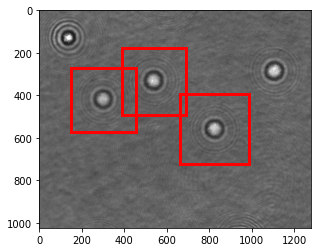

,x_p,y_p,z_p,a_p,n_p,k_p,n_m,wavelength,magnification,alpha,shape,model,coordinates,bboxes,framenumber
0,825.740662,559.208679,235.419632,1.538465,1.504688,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((331, 331), (660, 394))","(825.7406616210938, 559.2086791992188, 324.609...",2
1,539.760254,334.576385,168.743347,1.558882,1.492592,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((312, 312), (384, 179))","(539.76025390625, 334.5763854980469, 301.90222...",2
2,302.090271,420.853729,236.382217,1.516618,1.498676,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((303, 303), (151, 269))","(302.09027099609375, 420.8537292480469, 303.66...",2


In [6]:
video.frames[2].show()
display(video.frames[2].to_df())

In [9]:
## Refinement
count = 0
t0=time()
for frame in video.frames:
    t=time()
    count += 1
    frame.optimize()
    print('Refined frame {} in {}'.format(count, time()-t))
video.clear_trajectories()
print('After Refinement:')
video.set_trajectories(link=False)
display(video.trajectories)
print()
print('Refined in {}'.format(time()-t0))

t0=time()
video.serialize(save=True, path='refined', omit_feat=['data'])
print('Serialized in {}'.format(time()-t0))

Refining frame 0
FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3933987.275452846
nfev: 412
x_p: 823.69674 (init: 824.52417)
y_p: 555.13227 (init: 559.02814)
z_p: 180.36199 (init: 197.23973)
a_p: 1.23004 (init: 0.92898)
n_p: 1.38612 (init: 1.50649)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3985664.7484955606
nfev: 286
x_p: 543.13111 (init: 537.85449)
y_p: 368.94994 (init: 334.57278)
z_p: 221.48714 (init: 242.23346)
a_p: 2.12405 (init: 2.14439)
n_p: 1.47524 (init: 1.47509)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (ini

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3936059.0693475115
nfev: 428
x_p: 572.91215 (init: 537.11401)
y_p: 346.99506 (init: 334.22525)
z_p: 217.40813 (init: 204.49365)
a_p: 1.94932 (init: 1.63013)
n_p: 1.46745 (init: 1.56114)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3845606.279290072
nfev: 374
x_p: 311.28402 (init: 302.44336)
y_p: 427.94859 (init: 417.86157)
z_p: 261.34362 (init: 253.14485)
a_p: 1.64608 (init: 1.61108)
n_p: 1.57138 (init: 1.57171)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3842105.6008592662
nfev: 310
x_p: 308.01651 (init: 299.41553)
y_p: 426.68820 (init: 417.78564)
z_p: 206.94310 (init: 187.12077)
a_p: 1.35611 (init: 1.40629)
n_p: 1.62057 (init: 1.56416)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 11
FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3894258.821634377
nfev: 155
x_p: 828.76481 (init: 825.76355)
y_p: 557.39359 (init: 557.45435)
z_p: 313.32591 (init: 312.52484)
a_p: 1.08610 (init: 1.07882)
n_p: 1.63484 (init: 1.59140)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (in

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3990781.218921449
nfev: 354
x_p: 527.55961 (init: 536.78320)
y_p: 345.24594 (init: 333.10187)
z_p: 270.66676 (init: 191.31996)
a_p: 4.00000 (init: 1.61182)
n_p: 1.36674 (init: 1.44334)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3929738.397444723
nfev: 344
x_p: 808.06606 (init: 825.21759)
y_p: 582.72693 (init: 557.93628)
z_p: 205.80109 (init: 216.94901)
a_p: 1.30995 (init: 1.34904)
n_p: 1.49022 (init: 1.49389)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3875472.9239058695
nfev: 496
x_p: 297.93197 (init: 301.59641)
y_p: 424.48974 (init: 418.42746)
z_p: 228.62770 (init: 233.78255)
a_p: 0.90565 (init: 1.40445)
n_p: 1.67482 (init: 1.48661)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3974175.2089260565
nfev: 388
x_p: 541.89034 (init: 538.32788)
y_p: 342.68356 (init: 332.98669)
z_p: 192.20063 (init: 241.57237)
a_p: 4.00000 (init: 1.56830)
n_p: 1.37741 (init: 1.44944)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fi

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3953741.848638541
nfev: 379
x_p: 542.26450 (init: 538.35541)
y_p: 333.89793 (init: 334.08850)
z_p: 337.47727 (init: 251.18756)
a_p: 4.00000 (init: 2.01939)
n_p: 1.35612 (init: 1.44842)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 27
FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3974033.4845836605
nfev: 461
x_p: 539.50053 (init: 536.59253)
y_p: 340.94022 (init: 334.85233)
z_p: 351.14978 (init: 264.79736)
a_p: 4.00000 (init: 1.93511)
n_p: 1.35814 (init: 1.44832)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3967789.361430889
nfev: 386
x_p: 538.52986 (init: 537.57806)
y_p: 345.97312 (init: 334.44302)
z_p: 246.46634 (init: 208.08736)
a_p: 4.00000 (init: 1.61318)
n_p: 1.37555 (init: 1.47358)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3925352.345306298
nfev: 653
x_p: 827.68008 (init: 826.00415)
y_p: 556.69582 (init: 556.59381)
z_p: 213.17050 (init: 238.54706)
a_p: 0.43865 (init: 1.10070)
n_p: 1.50071 (init: 1.48632)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3946485.301693517
nfev: 226
x_p: 551.97190 (init: 538.21771)
y_p: 333.06841 (init: 333.46683)
z_p: 302.67609 (init: 241.92708)
a_p: 4.00000 (init: 1.76071)
n_p: 1.36324 (init: 1.43964)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3818185.3712582644
nfev: 171
x_p: 299.38757 (init: 300.21692)
y_p: 419.68830 (init: 418.84451)
z_p: 175.36095 (init: 173.99707)
a_p: 1.37102 (init: 1.41790)
n_p: 1.71626 (init: 1.64306)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fix

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3950166.7756343
nfev: 219
x_p: 557.78204 (init: 539.70081)
y_p: 332.58370 (init: 335.58768)
z_p: 208.12438 (init: 143.93944)
a_p: 4.00000 (init: 1.82452)
n_p: 1.37197 (init: 1.44714)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 43
FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3943053.9596735914
nfev: 340
x_p: 808.26889 (init: 826.80145)
y_p: 571.79427 (init: 557.62128)
z_p: 280.32745 (init: 280.47849)
a_p: 1.09222 (init: 1.17835)
n_p: 1.47671 (init: 1.49488)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (ini

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3975873.90215936
nfev: 404
x_p: 515.08797 (init: 535.72968)
y_p: 346.97240 (init: 333.89688)
z_p: 221.82333 (init: 221.26434)
a_p: 1.82507 (init: 1.97559)
n_p: 1.48920 (init: 1.45617)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (hit max evals)
redchi: 3933181.8756289887
nfev: 801
x_p: 802.95112 (init: 826.81384)
y_p: 558.16648 (init: 560.01892)
z_p: 248.40544 (init: 252.50812)
a_p: 1.38604 (init: 0.84575)
n_p: 1.42994 (init: 1.50798)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
a

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 4119235.4860177943
nfev: 327
x_p: 550.07172 (init: 537.77679)
y_p: 340.89289 (init: 334.52039)
z_p: 248.40489 (init: 132.10645)
a_p: 4.00000 (init: 0.96401)
n_p: 1.39943 (init: 1.48623)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3951738.0863396404
nfev: 350
x_p: 296.13628 (init: 301.03430)
y_p: 419.85971 (init: 418.91577)
z_p: 218.22769 (init: 212.49860)
a_p: 0.70926 (init: 0.68846)
n_p: 1.77244 (init: 1.63482)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fi

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3844883.222048401
nfev: 308
x_p: 310.88871 (init: 299.63019)
y_p: 419.15774 (init: 417.38022)
z_p: 147.12225 (init: 154.09946)
a_p: 1.05312 (init: 1.06101)
n_p: 1.71223 (init: 1.68901)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 59
FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3949272.38418926
nfev: 272
x_p: 530.83762 (init: 537.48932)
y_p: 349.57074 (init: 334.73828)
z_p: 255.95321 (init: 198.37135)
a_p: 4.00000 (init: 1.81795)
n_p: 1.38959 (init: 1.45771)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (ini

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3945473.9337399844
nfev: 325
x_p: 837.73261 (init: 826.66711)
y_p: 549.94795 (init: 559.20978)
z_p: 534.03899 (init: 230.42371)
a_p: 4.00000 (init: 1.04766)
n_p: 1.35497 (init: 1.49295)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3837867.7466894574
nfev: 262
x_p: 304.22815 (init: 299.60947)
y_p: 422.65446 (init: 418.60156)
z_p: 170.35768 (init: 169.88895)
a_p: 1.40584 (init: 1.46286)
n_p: 1.66712 (init: 1.61188)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fi

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3863922.2296145707
nfev: 354
x_p: 306.68988 (init: 301.65457)
y_p: 418.90827 (init: 417.39474)
z_p: 169.47473 (init: 165.03604)
a_p: 1.38884 (init: 1.37731)
n_p: 1.57047 (init: 1.61925)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3985998.4259454985
nfev: 339
x_p: 554.50282 (init: 538.16138)
y_p: 333.84267 (init: 333.95123)
z_p: 319.37401 (init: 236.47562)
a_p: 4.00000 (init: 1.84491)
n_p: 1.35715 (init: 1.48681)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fi

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3859566.9791138466
nfev: 483
x_p: 295.97209 (init: 299.50842)
y_p: 424.30532 (init: 416.22900)
z_p: 133.02464 (init: 134.37831)
a_p: 1.27403 (init: 0.96119)
n_p: 1.43926 (init: 1.50426)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 75
FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3932777.777749991
nfev: 329
x_p: 546.40660 (init: 537.44299)
y_p: 329.60685 (init: 334.08627)
z_p: 164.13009 (init: 172.18732)
a_p: 1.38061 (init: 1.60288)
n_p: 1.42019 (init: 1.45978)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (in

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3880729.861859112
nfev: 464
x_p: 849.23278 (init: 827.39294)
y_p: 558.85843 (init: 558.62885)
z_p: 298.00660 (init: 297.37848)
a_p: 1.72974 (init: 1.37598)
n_p: 1.43714 (init: 1.48352)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3951701.794481224
nfev: 174
x_p: 533.67133 (init: 537.97375)
y_p: 333.29673 (init: 333.73898)
z_p: 280.81562 (init: 217.11653)
a_p: 4.00000 (init: 1.76325)
n_p: 1.35985 (init: 1.45245)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3950455.8220139793
nfev: 66
x_p: 829.93241 (init: 826.73395)
y_p: 551.09188 (init: 556.94257)
z_p: 299.54208 (init: 271.09106)
a_p: 0.05000 (init: 0.98928)
n_p: 2.22834 (init: 1.57038)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3855777.516745821
nfev: 301
x_p: 299.25029 (init: 298.86795)
y_p: 414.93003 (init: 417.85019)
z_p: 168.37364 (init: 168.96918)
a_p: 1.88907 (init: 1.89438)
n_p: 1.56673 (init: 1.52400)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3855125.9129892164
nfev: 219
x_p: 316.87856 (init: 301.66357)
y_p: 426.61718 (init: 418.28452)
z_p: 176.59107 (init: 204.51572)
a_p: 1.56389 (init: 1.49393)
n_p: 1.38192 (init: 1.53579)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 91
FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 4131259.623026995
nfev: 224
x_p: 818.49176 (init: 825.33875)
y_p: 557.35990 (init: 557.87122)
z_p: 191.81402 (init: 192.20435)
a_p: 0.60127 (init: 0.59685)
n_p: 1.41046 (init: 1.48933)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (in

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3969379.5712517602
nfev: 438
x_p: 526.98991 (init: 537.01428)
y_p: 362.89941 (init: 334.59036)
z_p: 191.67558 (init: 163.85910)
a_p: 1.55134 (init: 1.60488)
n_p: 1.46803 (init: 1.48486)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3947266.0481112953
nfev: 271
x_p: 823.19978 (init: 826.69409)
y_p: 563.70336 (init: 559.21716)
z_p: 225.53137 (init: 224.03200)
a_p: 1.16719 (init: 1.18814)
n_p: 1.55994 (init: 1.48343)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fix

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3936864.7156254076
nfev: 540
x_p: 828.96859 (init: 827.30969)
y_p: 558.21972 (init: 560.16876)
z_p: 235.02772 (init: 236.30559)
a_p: 0.83895 (init: 1.21411)
n_p: 1.70004 (init: 1.51205)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3872045.5228319103
nfev: 739
x_p: 293.58029 (init: 298.90683)
y_p: 419.35427 (init: 416.40164)
z_p: 188.97664 (init: 174.22104)
a_p: 0.41380 (init: 0.98495)
n_p: 2.50040 (init: 1.63582)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fix

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3805559.038939634
nfev: 300
x_p: 300.00618 (init: 299.24524)
y_p: 427.99715 (init: 417.64291)
z_p: 179.76895 (init: 181.60611)
a_p: 1.77368 (init: 1.78052)
n_p: 1.56604 (init: 1.56118)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 107
FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3925616.7930668336
nfev: 543
x_p: 825.38336 (init: 826.13159)
y_p: 567.20630 (init: 558.05188)
z_p: 214.37569 (init: 222.26643)
a_p: 4.00000 (init: 1.18440)
n_p: 1.37642 (init: 1.50611)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3974455.3923073076
nfev: 397
x_p: 825.72214 (init: 826.43579)
y_p: 558.15512 (init: 559.01483)
z_p: 234.00860 (init: 249.54218)
a_p: 0.70737 (init: 1.39708)
n_p: 1.76723 (init: 1.50425)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3848293.7866572463
nfev: 475
x_p: 295.74099 (init: 301.59222)
y_p: 416.84717 (init: 420.15521)
z_p: 175.31282 (init: 208.17957)
a_p: 4.00000 (init: 1.51731)
n_p: 1.41397 (init: 1.48777)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fi

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3919678.2477858867
nfev: 446
x_p: 822.90628 (init: 825.11230)
y_p: 570.93473 (init: 557.88470)
z_p: 404.57136 (init: 226.73367)
a_p: 4.00000 (init: 1.17838)
n_p: 1.37368 (init: 1.46761)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3813708.527049011
nfev: 336
x_p: 291.23355 (init: 302.94803)
y_p: 427.54572 (init: 419.74481)
z_p: 218.50388 (init: 206.55786)
a_p: 1.47523 (init: 1.45473)
n_p: 1.72811 (init: 1.72320)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fix

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3827344.8234555605
nfev: 285
x_p: 308.58883 (init: 301.28772)
y_p: 417.66858 (init: 421.49396)
z_p: 216.28270 (init: 218.24902)
a_p: 2.09541 (init: 2.06178)
n_p: 1.53821 (init: 1.53354)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 123
FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3969058.2011437933
nfev: 229
x_p: 533.48680 (init: 537.66992)
y_p: 318.66537 (init: 334.06522)
z_p: 196.51817 (init: 220.30887)
a_p: 4.00000 (init: 1.90438)
n_p: 1.36160 (init: 1.45270)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3900658.1874667
nfev: 499
x_p: 827.34943 (init: 825.36383)
y_p: 531.48068 (init: 558.49829)
z_p: 288.79021 (init: 287.34402)
a_p: 1.26743 (init: 1.32560)
n_p: 1.46868 (init: 1.47686)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3971488.8504348756
nfev: 237
x_p: 523.16802 (init: 538.14349)
y_p: 355.18472 (init: 335.83600)
z_p: 146.06488 (init: 151.02840)
a_p: 1.84208 (init: 1.82895)
n_p: 1.50390 (init: 1.52644)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3905779.1934988694
nfev: 355
x_p: 862.20308 (init: 825.39117)
y_p: 562.68061 (init: 559.92834)
z_p: 194.16741 (init: 263.35236)
a_p: 1.39202 (init: 1.31040)
n_p: 1.49984 (init: 1.47257)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3819422.238851126
nfev: 187
x_p: 308.49413 (init: 302.64117)
y_p: 425.08685 (init: 419.82892)
z_p: 221.18459 (init: 221.89606)
a_p: 1.71176 (init: 1.71346)
n_p: 1.55653 (init: 1.55008)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3832915.826569417
nfev: 475
x_p: 304.89529 (init: 300.05661)
y_p: 419.96970 (init: 417.70990)
z_p: 225.98809 (init: 234.42110)
a_p: 1.22923 (init: 1.41701)
n_p: 1.58706 (init: 1.52288)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 139
FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3961485.4137737034
nfev: 313
x_p: 811.43961 (init: 826.24750)
y_p: 563.56040 (init: 558.52539)
z_p: 97.87987 (init: 305.01736)
a_p: 4.00000 (init: 1.42273)
n_p: 1.41480 (init: 1.47676)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (i

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3951840.3727389844
nfev: 667
x_p: 830.95741 (init: 826.35651)
y_p: 565.91626 (init: 557.47845)
z_p: 283.59124 (init: 271.74811)
a_p: 1.15614 (init: 1.48623)
n_p: 1.61960 (init: 1.49284)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3960829.6831259467
nfev: 722
x_p: 553.13191 (init: 538.08722)
y_p: 330.47169 (init: 335.64206)
z_p: 151.77907 (init: 220.69768)
a_p: 4.00000 (init: 1.93371)
n_p: 1.41099 (init: 1.47364)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fi

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3968474.380104473
nfev: 455
x_p: 531.99119 (init: 537.94385)
y_p: 326.84357 (init: 334.31039)
z_p: 222.27494 (init: 171.17279)
a_p: 4.00000 (init: 1.92852)
n_p: 1.37540 (init: 1.52017)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3850062.723136581
nfev: 275
x_p: 301.55934 (init: 300.69135)
y_p: 420.67485 (init: 418.84637)
z_p: 253.44534 (init: 254.54944)
a_p: 1.58228 (init: 1.61121)
n_p: 1.72980 (init: 1.67184)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3953859.774698764
nfev: 597
x_p: 537.08700 (init: 538.32776)
y_p: 336.32713 (init: 335.93008)
z_p: 87.23266 (init: 167.81400)
a_p: 4.00000 (init: 1.81911)
n_p: 1.48567 (init: 1.47334)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 155
FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3916569.591672912
nfev: 414
x_p: 801.60351 (init: 826.00391)
y_p: 556.12210 (init: 560.66107)
z_p: 292.53798 (init: 312.14154)
a_p: 0.83290 (init: 1.39335)
n_p: 1.92974 (init: 1.48949)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (in

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3959140.8601994617
nfev: 231
x_p: 536.90250 (init: 536.95093)
y_p: 338.64657 (init: 334.39545)
z_p: 208.75554 (init: 146.35968)
a_p: 4.00000 (init: 1.43196)
n_p: 1.35252 (init: 1.47764)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3926662.595833532
nfev: 483
x_p: 811.68188 (init: 825.29913)
y_p: 573.55087 (init: 559.18207)
z_p: 304.36210 (init: 288.75714)
a_p: 1.63085 (init: 1.23057)
n_p: 1.40744 (init: 1.46341)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fix

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3964989.5983639346
nfev: 423
x_p: 851.72563 (init: 828.82257)
y_p: 550.70694 (init: 559.18671)
z_p: 295.84031 (init: 294.98792)
a_p: 1.40909 (init: 1.01636)
n_p: 1.41978 (init: 1.45803)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3810193.131111046
nfev: 155
x_p: 301.40106 (init: 300.24606)
y_p: 419.28749 (init: 416.44748)
z_p: 175.62689 (init: 179.24474)
a_p: 1.97235 (init: 1.94572)
n_p: 1.52788 (init: 1.55636)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3825316.354952384
nfev: 221
x_p: 302.66217 (init: 299.60657)
y_p: 421.41450 (init: 417.87512)
z_p: 175.50799 (init: 164.94939)
a_p: 1.25666 (init: 1.28123)
n_p: 1.73165 (init: 1.71538)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 171
FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3917052.101791114
nfev: 734
x_p: 828.18768 (init: 825.45764)
y_p: 540.55455 (init: 558.16010)
z_p: 248.46278 (init: 232.47757)
a_p: 1.36689 (init: 1.00498)
n_p: 1.37665 (init: 1.50459)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (in

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3940488.1014081305
nfev: 165
x_p: 542.27529 (init: 537.67792)
y_p: 336.23492 (init: 334.53339)
z_p: 179.50297 (init: 185.26805)
a_p: 2.12639 (init: 2.08909)
n_p: 1.44863 (init: 1.48978)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3939754.315270552
nfev: 458
x_p: 822.32061 (init: 825.59174)
y_p: 575.73978 (init: 559.54614)
z_p: 213.97065 (init: 220.42400)
a_p: 0.92497 (init: 0.94131)
n_p: 1.41190 (init: 1.50569)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3943900.065983467
nfev: 472
x_p: 838.59392 (init: 825.75659)
y_p: 585.79198 (init: 559.13568)
z_p: 220.72931 (init: 240.08075)
a_p: 0.98620 (init: 0.97341)
n_p: 1.47492 (init: 1.50403)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3777481.039964623
nfev: 189
x_p: 304.84190 (init: 303.12366)
y_p: 416.64438 (init: 418.68024)
z_p: 130.99551 (init: 129.30087)
a_p: 1.77161 (init: 1.78608)
n_p: 1.65776 (init: 1.63592)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3795351.2660617176
nfev: 179
x_p: 304.74941 (init: 303.65533)
y_p: 421.31763 (init: 418.99976)
z_p: 179.99285 (init: 176.16785)
a_p: 1.71638 (init: 1.72899)
n_p: 1.62190 (init: 1.59900)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 187
FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3968601.7970536514
nfev: 342
x_p: 833.76757 (init: 826.04828)
y_p: 554.41273 (init: 557.16321)
z_p: 564.67430 (init: 368.94855)
a_p: 4.00000 (init: 1.25409)
n_p: 1.35414 (init: 1.48356)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3992150.052237552
nfev: 266
x_p: 531.86720 (init: 537.78485)
y_p: 337.21922 (init: 334.05142)
z_p: 282.93052 (init: 278.45087)
a_p: 2.17919 (init: 2.17700)
n_p: 1.52094 (init: 1.50246)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3947195.988621513
nfev: 431
x_p: 788.50308 (init: 826.36652)
y_p: 599.88526 (init: 558.69208)
z_p: 256.60636 (init: 252.78714)
a_p: 1.60909 (init: 1.25936)
n_p: 1.41084 (init: 1.48085)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3962079.8899098793
nfev: 252
x_p: 542.46832 (init: 540.22205)
y_p: 338.20587 (init: 334.54913)
z_p: 233.90311 (init: 227.99191)
a_p: 2.21177 (init: 2.25405)
n_p: 1.52401 (init: 1.51217)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3795187.2780142506
nfev: 249
x_p: 301.24550 (init: 301.48309)
y_p: 414.22412 (init: 416.39679)
z_p: 165.83234 (init: 161.26474)
a_p: 1.63192 (init: 1.66707)
n_p: 1.58869 (init: 1.55498)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fix

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3786098.690994679
nfev: 296
x_p: 256.50757 (init: 302.20435)
y_p: 431.76412 (init: 415.83694)
z_p: 176.05286 (init: 167.95462)
a_p: 1.91660 (init: 1.90588)
n_p: 1.64560 (init: 1.56749)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 203
FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3901964.78535769
nfev: 404
x_p: 827.34242 (init: 827.64868)
y_p: 554.52472 (init: 557.93439)
z_p: 230.02896 (init: 229.77127)
a_p: 0.83784 (init: 1.27477)
n_p: 1.69515 (init: 1.54178)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (ini

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3942281.2027636417
nfev: 596
x_p: 871.28963 (init: 826.74103)
y_p: 513.34020 (init: 558.17163)
z_p: 421.68759 (init: 342.73969)
a_p: 4.00000 (init: 1.29992)
n_p: 1.37437 (init: 1.56027)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3964293.682976352
nfev: 289
x_p: 535.30161 (init: 537.53821)
y_p: 339.94528 (init: 334.67908)
z_p: 113.47343 (init: 124.23399)
a_p: 2.00175 (init: 2.00186)
n_p: 1.56967 (init: 1.55614)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fix

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3931485.691557995
nfev: 462
x_p: 831.55594 (init: 827.75854)
y_p: 565.81212 (init: 559.41571)
z_p: 184.59803 (init: 228.54222)
a_p: 0.05000 (init: 1.54420)
n_p: 2.06764 (init: 1.53871)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3755114.3771876898
nfev: 339
x_p: 305.38615 (init: 301.41495)
y_p: 419.40365 (init: 420.03363)
z_p: 237.33208 (init: 239.41377)
a_p: 1.99057 (init: 2.02482)
n_p: 1.56650 (init: 1.55935)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fix

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3766649.383284627
nfev: 148
x_p: 302.92529 (init: 300.17743)
y_p: 415.44047 (init: 416.42535)
z_p: 244.03739 (init: 242.95891)
a_p: 2.03031 (init: 2.04646)
n_p: 1.58813 (init: 1.57470)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 219
FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3968088.4600465004
nfev: 308
x_p: 815.18134 (init: 825.53778)
y_p: 559.12047 (init: 557.48914)
z_p: 200.71163 (init: 243.93810)
a_p: 0.05000 (init: 1.63310)
n_p: 1.78090 (init: 1.50668)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3902164.3018216672
nfev: 498
x_p: 838.98142 (init: 828.98096)
y_p: 577.42492 (init: 558.00659)
z_p: 284.89818 (init: 295.79663)
a_p: 1.45340 (init: 1.34554)
n_p: 1.47181 (init: 1.45777)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3769061.2081401963
nfev: 575
x_p: 309.14570 (init: 301.04251)
y_p: 419.20452 (init: 417.93924)
z_p: 266.06707 (init: 198.12169)
a_p: 4.00000 (init: 1.79475)
n_p: 1.35919 (init: 1.52409)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fi

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3906683.564816006
nfev: 351
x_p: 812.72452 (init: 826.89966)
y_p: 550.64098 (init: 557.76685)
z_p: 468.17874 (init: 311.73676)
a_p: 4.00000 (init: 1.19196)
n_p: 1.37376 (init: 1.48978)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3764791.268866786
nfev: 208
x_p: 304.71145 (init: 299.76276)
y_p: 419.77590 (init: 416.51773)
z_p: 183.05291 (init: 187.56287)
a_p: 1.73434 (init: 1.72619)
n_p: 1.60187 (init: 1.60022)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3746281.942237224
nfev: 181
x_p: 297.51691 (init: 300.51831)
y_p: 422.02733 (init: 418.25620)
z_p: 132.24525 (init: 136.53986)
a_p: 1.94477 (init: 1.93510)
n_p: 1.61779 (init: 1.61760)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

Refining frame 235
FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3969524.361300123
nfev: 389
x_p: 526.64013 (init: 537.30933)
y_p: 349.81520 (init: 336.20572)
z_p: 210.87568 (init: 157.13591)
a_p: 4.00000 (init: 2.42703)
n_p: 1.40639 (init: 1.49500)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (i

FIT REPORT
---------------------------------------------
method: amoeba
success: False
message: failure (stuck to boundary)
redchi: 3982608.2998278406
nfev: 591
x_p: 544.90781 (init: 536.24152)
y_p: 334.33626 (init: 335.48953)
z_p: 214.56296 (init: 209.84222)
a_p: 4.00000 (init: 1.94469)
n_p: 1.39097 (init: 1.47028)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3912021.4723457126
nfev: 318
x_p: 830.00874 (init: 825.50970)
y_p: 558.44073 (init: 558.19141)
z_p: 229.73680 (init: 228.31485)
a_p: 0.98049 (init: 1.09389)
n_p: 1.64206 (init: 1.52517)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fi

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3962553.8017094964
nfev: 520
x_p: 575.30790 (init: 537.71448)
y_p: 352.96067 (init: 335.71164)
z_p: 201.69149 (init: 204.73903)
a_p: 1.96810 (init: 2.20193)
n_p: 1.47782 (init: 1.50622)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: amoeba
success: True
message: convergence (simplex small)
redchi: 3774881.709044142
nfev: 328
x_p: 308.60358 (init: 301.90784)
y_p: 421.31325 (init: 416.71402)
z_p: 273.90021 (init: 273.51001)
a_p: 2.02716 (init: 2.07474)
n_p: 1.75781 (init: 1.70738)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.33500 (init: 1.33500) (fixed)
wavelength: 0.53200 (init: 0.53200) (fixed)
magnification: 0.13500 (init: 0.13500) (fixe

,x_p,y_p,z_p,a_p,n_p,k_p,n_m,wavelength,magnification,alpha,shape,model,coordinates,bboxes,framenumber
0,823.696735,555.132275,180.361985,1.230035,1.386119,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((330, 330), (660, 394))","(824.524169921875, 559.0281372070312, 318.3036...",0
1,543.131115,368.949937,221.487140,2.124046,1.475245,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((317, 317), (379, 176))","(537.8544921875, 334.5727844238281, 317.359283...",0
2,265.884709,433.227531,185.089290,1.777210,1.482435,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((313, 313), (145, 260))","(301.4091796875, 416.9522399902344, 309.685516...",0
0,805.279093,584.698446,264.962025,1.359102,1.495431,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((335, 335), (658, 392))","(825.27587890625, 559.1727294921875, 325.13543...",1
1,279.661594,427.086143,220.447484,1.831897,1.415338,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((314, 314), (144, 260))","(301.2391357421875, 416.51873779296875, 313.51...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,532.138917,322.410879,139.145042,4.000000,1.361001,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((317, 317), (379, 177))","(537.721435546875, 335.9896240234375, 312.7586...",247
2,307.798490,416.822633,177.362946,1.965913,1.336244,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((308, 308), (146, 262))","(299.9382629394531, 416.14630126953125, 307.24...",247
0,560.333667,357.168922,173.125991,2.177178,1.482315,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((321, 321), (377, 175))","(537.4176025390625, 335.85284423828125, 321.80...",248
1,831.983280,546.566829,113.532189,2.654658,1.409710,0.0,1.335,0.532,0.135,1.0,None,LMHologram,"((332, 332), (661, 394))","(826.5648803710938, 559.6766357421875, 321.907...",248


{'frames': {0: {'features': [{'x_p': 823.696735197848,
     'y_p': 555.1322745797489,
     'z_p': 180.36198529963107,
     'a_p': 1.2300353687425638,
     'n_p': 1.3861190505559913,
     'k_p': 0.0,
     'n_m': 1.335,
     'wavelength': 0.532,
     'magnification': 0.135,
     'alpha': 1.0,
     'shape': None,
     'model': 'LMHologram',
     'coordinates': ((330, 330), (660, 394))},
    {'x_p': 543.1311146249928,
     'y_p': 368.94993706186466,
     'z_p': 221.48713988251205,
     'a_p': 2.1240458732725327,
     'n_p': 1.4752447585422204,
     'k_p': 0.0,
     'n_m': 1.335,
     'wavelength': 0.532,
     'magnification': 0.135,
     'alpha': 1.0,
     'shape': None,
     'model': 'LMHologram',
     'coordinates': ((317, 317), (379, 176))},
    {'x_p': 265.88470898509235,
     'y_p': 433.2275306559161,
     'z_p': 185.0892897259883,
     'a_p': 1.777210006666968,
     'n_p': 1.4824347996807032,
     'k_p': 0.0,
     'n_m': 1.335,
     'wavelength': 0.532,
     'magnification': 0.135,
 

# Analysis

Frame 248: 3 trajectories present.


/home/group/anaconda3/envs/JackieCNN/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/group/anaconda3/envs/JackieCNN/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/group/anaconda3/envs/JackieCNN/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an a

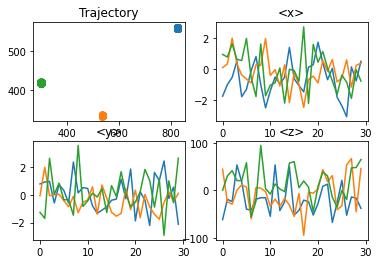

In [9]:
video.clear_trajectories()
video.set_trajectories(search_range=10, memory=1)
for i in set(video.trajectories.particle):
    traj = video.trajectories[video.trajectories.particle==i]
    x = traj.x_p.to_numpy()
    y = traj.y_p.to_numpy()
    z = traj.z_p.to_numpy()
    plt.subplot(2, 2, 1); plt.scatter(x, y, label='Trajectory {} (length {})'.format(i, len(x))); plt.title('Trajectory')
    plt.subplot(2, 2, 2); plt.plot( (x-np.mean(x))[:30] ); plt.title('<x>');
    plt.subplot(2, 2, 3); plt.plot( (y-np.mean(y))[:30] ); plt.title('<y>');
    plt.subplot(2, 2, 4); plt.plot( (z-np.mean(z))[:30]); plt.title('<z>');
# plt.legend()
plt.show()

/home/group/anaconda3/envs/JackieCNN/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/group/anaconda3/envs/JackieCNN/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/group/anaconda3/envs/JackieCNN/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


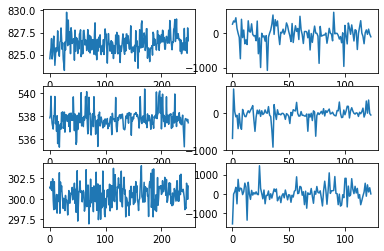

In [10]:
df = video.trajectories
n = max(df.particle.to_list())
for i in set(df.particle):
    dfi = df[df.particle==i]
    plt.subplot(n+1, 2, 2*i+1)
    plt.plot(dfi.x_p.to_list())
    plt.subplot(n+1, 2, 2*i+2)
    plt.plot(np.fft.rfft(dfi.x_p.to_numpy())[1:]**2)
plt.show()

# 'Predict' Timing

Prediction is currently done by loading images in one-at-a-time, calling EndtoEnd.predict(), and writing the results to a json file. In turn, EndtoEnd is an object which 

i) localizes features on an image

ii) runs no_edges and nodoubles to filter detections

iii) crops the image to obtain stamp for each feature

iv) obtains reshaped, scaled crops of each image to provide to the estimator

v) uses estimator input to estimate features


In [5]:
a = [(1, 2, 3, 4), (5, 6, 7, 8)]
print(np.shape(a))

(2, 4)


Let's start by timing the standard CNNLorenzMie's e2e:

In [3]:
start = time()
savedict = []

path = 'aug1_v2/tobot_0hz400' + '/norm_images'
numimgs = 6

e2e = EndtoEnd(estimator=est, localizer=loc)

savedict = []

t0 = time()
t = time()

#just do one at a time for now
for i in range(numimgs):
    filepath = path + '/image' + str(i).zfill(4) + '.png'
    localim = cv2.imread(filepath)
    features = e2e.predict(img_list = [localim])[0]
    for feature in features:
        localdict = feature.serialize(exclude=['data'])
        localdict['framenum'] = i
        localdict['framepath'] = os.path.abspath(filepath)
        savedict.append(localdict)
    print('Completed frame {} in {}'.format(i, time() - t), end='\r')
    print(pd.DataFrame.from_dict(localdict))
    #         print(localdict)
    print()
    t = time()

print('finished in {}'.format(time()-t0))

with open('your_MLpreds.json', 'w') as f:
    json.dump(savedict, f)
print('saved ML')


crop_px: (201, 201)
formatee shape: (8, 201, 201)
channels_notfirst
formatted shape: (8, 201, 201, 1)
formatted type: <class 'numpy.ndarray'>
input crop shape: (8, 201, 201, 1), type: <class 'numpy.ndarray'>
Estimation:
          z_p       a_p       n_p
0  452.282593  2.304379  1.487195
1  549.689575  1.597544  1.746281
2  518.074829  1.871237  1.505320
3  443.469604  1.852226  1.947495
4  577.859070  2.300572  1.590992
5  523.161133  2.053328  1.951467
6  136.268600  1.997781  1.549600
7  258.044861  0.933988  2.069993
           x_p         y_p         z_p       a_p       n_p  k_p    n_m  \
0  1103.462158  906.350647  258.044861  0.933988  2.069993  0.0  1.335   
1  1103.462158  906.350647  258.044861  0.933988  2.069993  0.0  1.335   

   wavelength  magnification  alpha shape       model coordinates  framenum  \
0       0.532          0.135    1.0  None  LMHologram  (310, 310)         0   
1       0.532          0.135    1.0  None  LMHologram  (924, 668)         0   

             

e2e'ing 6 frames (on my local pc) took about 150 seconds. Let's compare that to the new e2e:

obtained path test/tobot2_3p157hz100 from corresponding video path
YOLO predictions:
                                              bboxes framenumber
0  (139.7147216796875, 129.5660400390625, 302.518...           0
1  (1109.4521484375, 286.9127502441406, 305.83889...           0
2  (537.3046875, 333.4405212402344, 307.610870361...           0
3  (828.166015625, 556.222900390625, 302.16375732...           0
4  (302.6427307128906, 415.45587158203125, 306.22...           0



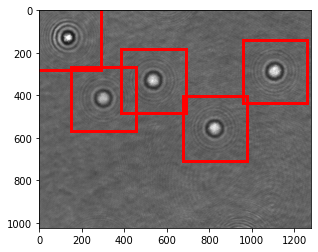

1
1
(1109.4521484375, 286.9127502441406, 305.8388977050781, 298.788818359375)
0
0
(139.7147216796875, 129.5660400390625, 302.518798828125, 302.9501953125)
After filtering:
                                              bboxes framenumber
0  (537.3046875, 333.4405212402344, 307.610870361...           0
1  (828.166015625, 556.222900390625, 302.16375732...           0
2  (302.6427307128906, 415.45587158203125, 306.22...           0



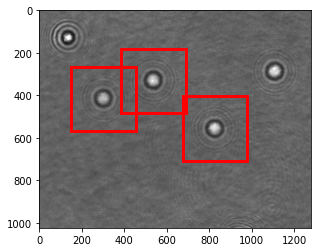

After cropping: 
          x_p         y_p    z_p  a_p  n_p  k_p    n_m  wavelength  \
0  537.304688  333.440521  100.0  1.0  1.5  0.0  1.335       0.532   
1  828.166016  556.222900  100.0  1.0  1.5  0.0  1.335       0.532   
2  302.642731  415.455872  100.0  1.0  1.5  0.0  1.335       0.532   

   magnification  alpha shape       model               coordinates  \
0          0.135    1.0  None  LMHologram  ((307, 307), (384, 180))   
1          0.135    1.0  None  LMHologram  ((306, 306), (675, 403))   
2          0.135    1.0  None  LMHologram  ((306, 306), (150, 262))   

                                              bboxes framenumber  
0  (537.3046875, 333.4405212402344, 307.610870361...           0  
1  (828.166015625, 556.222900390625, 302.16375732...           0  
2  (302.6427307128906, 415.45587158203125, 306.22...           0  

After estimation:
          x_p         y_p         z_p       a_p       n_p  k_p    n_m  \
0  537.304688  333.440521  222.689957  1.615240  1.438001

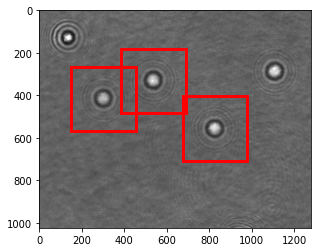

tload: 0.8694219589233398 | tloc: 20.425825357437134 | tcrop: 0.01444244384765625 | tfilt: 0.2431802749633789 | test: 0.34184789657592773 | twrite: 0.18340492248535156
YOLO predictions:
                                              bboxes framenumber
0  (140.2084197998047, 129.03428649902344, 303.00...           1
1  (1108.814208984375, 285.7316589355469, 302.874...           1
2  (828.9229736328125, 555.0838623046875, 306.715...           1
3  (538.1107177734375, 333.2938537597656, 308.335...           1
4  (302.1241455078125, 414.3705139160156, 309.506...           1



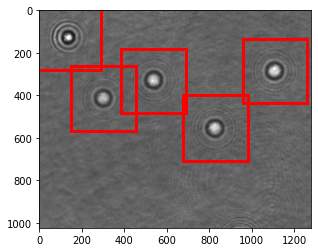

1
1
(1108.814208984375, 285.7316589355469, 302.8741149902344, 301.58538818359375)
0
0
(140.2084197998047, 129.03428649902344, 303.0032958984375, 299.049560546875)
After filtering:
                                              bboxes framenumber
0  (828.9229736328125, 555.0838623046875, 306.715...           1
1  (538.1107177734375, 333.2938537597656, 308.335...           1
2  (302.1241455078125, 414.3705139160156, 309.506...           1



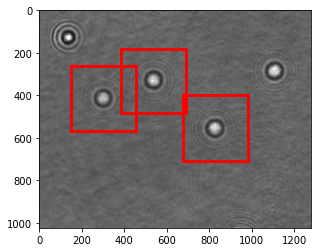

After cropping: 
          x_p         y_p    z_p  a_p  n_p  k_p    n_m  wavelength  \
0  828.922974  555.083862  100.0  1.0  1.5  0.0  1.335       0.532   
1  538.110718  333.293854  100.0  1.0  1.5  0.0  1.335       0.532   
2  302.124146  414.370514  100.0  1.0  1.5  0.0  1.335       0.532   

   magnification  alpha shape       model               coordinates  \
0          0.135    1.0  None  LMHologram  ((311, 311), (673, 400))   
1          0.135    1.0  None  LMHologram  ((308, 308), (384, 179))   
2          0.135    1.0  None  LMHologram  ((309, 309), (148, 260))   

                                              bboxes framenumber  
0  (828.9229736328125, 555.0838623046875, 306.715...           1  
1  (538.1107177734375, 333.2938537597656, 308.335...           1  
2  (302.1241455078125, 414.3705139160156, 309.506...           1  

After estimation:
          x_p         y_p         z_p       a_p       n_p  k_p    n_m  \
0  828.922974  555.083862  220.772125  1.682917  1.508069

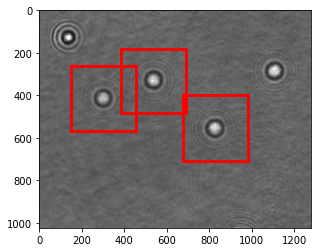

tload: 1.0744268894195557 | tloc: 41.74623775482178 | tcrop: 0.031751155853271484 | tfilt: 0.49710941314697266 | test: 0.6303009986877441 | twrite: 0.39493465423583984
YOLO predictions:
                                              bboxes framenumber
0  (140.77069091796875, 129.1630859375, 306.61657...           2
1  (1108.77392578125, 285.89910888671875, 304.641...           2
2  (827.0952758789062, 557.3518676757812, 306.127...           2
3  (537.485107421875, 333.629638671875, 303.29815...           2
4  (300.89617919921875, 415.3295593261719, 306.93...           2



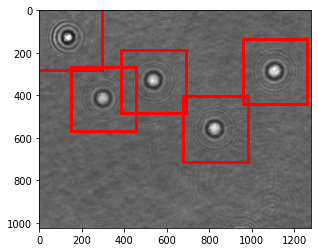

1
1
(1108.77392578125, 285.89910888671875, 304.6416320800781, 306.00518798828125)
0
0
(140.77069091796875, 129.1630859375, 306.6165771484375, 299.19781494140625)
After filtering:
                                              bboxes framenumber
0  (827.0952758789062, 557.3518676757812, 306.127...           2
1  (537.485107421875, 333.629638671875, 303.29815...           2
2  (300.89617919921875, 415.3295593261719, 306.93...           2



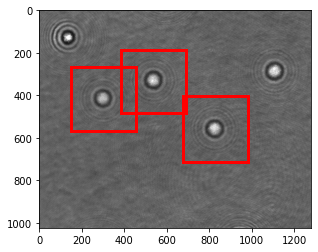

After cropping: 
          x_p         y_p    z_p  a_p  n_p  k_p    n_m  wavelength  \
0  827.095276  557.351868  100.0  1.0  1.5  0.0  1.335       0.532   
1  537.485107  333.629639  100.0  1.0  1.5  0.0  1.335       0.532   
2  300.896179  415.329559  100.0  1.0  1.5  0.0  1.335       0.532   

   magnification  alpha shape       model               coordinates  \
0          0.135    1.0  None  LMHologram  ((311, 311), (672, 402))   
1          0.135    1.0  None  LMHologram  ((303, 303), (386, 182))   
2          0.135    1.0  None  LMHologram  ((306, 306), (148, 262))   

                                              bboxes framenumber  
0  (827.0952758789062, 557.3518676757812, 306.127...           2  
1  (537.485107421875, 333.629638671875, 303.29815...           2  
2  (300.89617919921875, 415.3295593261719, 306.93...           2  

After estimation:
          x_p         y_p         z_p       a_p       n_p  k_p    n_m  \
0  827.095276  557.351868  198.736801  1.200324  1.607283

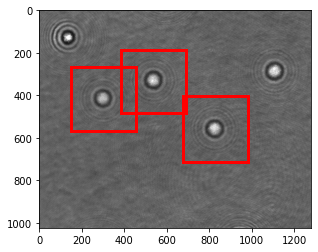

tload: 1.1182398796081543 | tloc: 63.41923141479492 | tcrop: 0.04567837715148926 | tfilt: 0.7305047512054443 | test: 0.9112045764923096 | twrite: 0.5941245555877686
YOLO predictions:
                                              bboxes framenumber
0  (138.3383331298828, 130.8441925048828, 297.030...           3
1  (1111.755126953125, 285.2766418457031, 307.440...           3
2  (829.4573974609375, 555.1116943359375, 305.133...           3
3  (537.79931640625, 332.30023193359375, 306.2536...           3
4  (301.7672119140625, 414.9330749511719, 306.099...           3



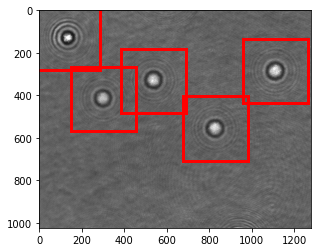

1
1
(1111.755126953125, 285.2766418457031, 307.44061279296875, 301.6552734375)
0
0
(138.3383331298828, 130.8441925048828, 297.0306701660156, 299.16943359375)
After filtering:
                                              bboxes framenumber
0  (829.4573974609375, 555.1116943359375, 305.133...           3
1  (537.79931640625, 332.30023193359375, 306.2536...           3
2  (301.7672119140625, 414.9330749511719, 306.099...           3



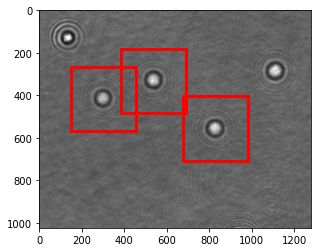

After cropping: 
          x_p         y_p    z_p  a_p  n_p  k_p    n_m  wavelength  \
0  829.457397  555.111694  100.0  1.0  1.5  0.0  1.335       0.532   
1  537.799316  332.300232  100.0  1.0  1.5  0.0  1.335       0.532   
2  301.767212  414.933075  100.0  1.0  1.5  0.0  1.335       0.532   

   magnification  alpha shape       model               coordinates  \
0          0.135    1.0  None  LMHologram  ((309, 309), (675, 401))   
1          0.135    1.0  None  LMHologram  ((306, 306), (385, 179))   
2          0.135    1.0  None  LMHologram  ((306, 306), (149, 262))   

                                              bboxes framenumber  
0  (829.4573974609375, 555.1116943359375, 305.133...           3  
1  (537.79931640625, 332.30023193359375, 306.2536...           3  
2  (301.7672119140625, 414.9330749511719, 306.099...           3  

After estimation:
          x_p         y_p         z_p       a_p       n_p  k_p    n_m  \
0  829.457397  555.111694  220.270996  1.461491  1.513138

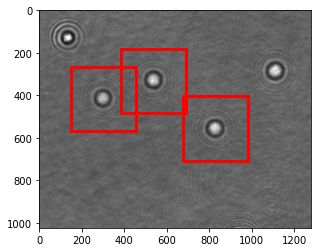

tload: 1.19573974609375 | tloc: 85.33964943885803 | tcrop: 0.06250381469726562 | tfilt: 0.9797844886779785 | test: 1.2010724544525146 | twrite: 0.7890303134918213
YOLO predictions:
                                              bboxes framenumber
0  (140.7139434814453, 130.1260528564453, 309.275...           4
1  (1109.4774169921875, 284.6618957519531, 309.21...           4
2  (829.4925537109375, 556.0098266601562, 310.102...           4
3  (538.0211181640625, 332.8164978027344, 308.146...           4
4  (300.38525390625, 415.037109375, 309.264465332...           4



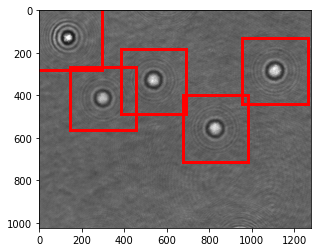

1
1
(1109.4774169921875, 284.6618957519531, 309.2173767089844, 308.7317199707031)
0
0
(140.7139434814453, 130.1260528564453, 309.27545166015625, 303.42645263671875)
After filtering:
                                              bboxes framenumber
0  (829.4925537109375, 556.0098266601562, 310.102...           4
1  (538.0211181640625, 332.8164978027344, 308.146...           4
2  (300.38525390625, 415.037109375, 309.264465332...           4



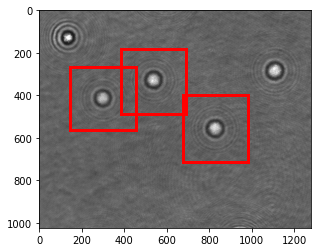

After cropping: 
          x_p         y_p    z_p  a_p  n_p  k_p    n_m  wavelength  \
0  829.492554  556.009827  100.0  1.0  1.5  0.0  1.335       0.532   
1  538.021118  332.816498  100.0  1.0  1.5  0.0  1.335       0.532   
2  300.385254  415.037109  100.0  1.0  1.5  0.0  1.335       0.532   

   magnification  alpha shape       model               coordinates  \
0          0.135    1.0  None  LMHologram  ((316, 316), (671, 398))   
1          0.135    1.0  None  LMHologram  ((308, 308), (384, 179))   
2          0.135    1.0  None  LMHologram  ((309, 309), (146, 261))   

                                              bboxes framenumber  
0  (829.4925537109375, 556.0098266601562, 310.102...           4  
1  (538.0211181640625, 332.8164978027344, 308.146...           4  
2  (300.38525390625, 415.037109375, 309.264465332...           4  

After estimation:
          x_p         y_p         z_p       a_p       n_p  k_p    n_m  \
0  829.492554  556.009827  237.123795  1.502644  1.451189

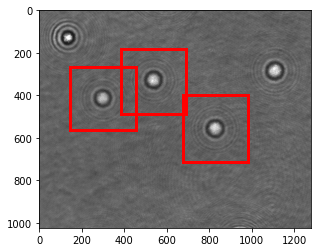

tload: 1.2386579513549805 | tloc: 106.73636817932129 | tcrop: 0.07748746871948242 | tfilt: 1.2317113876342773 | test: 1.475625991821289 | twrite: 0.9824497699737549
YOLO predictions:
                                              bboxes framenumber
0  (138.29440307617188, 127.67613220214844, 301.5...           5
1  (828.4598388671875, 557.8258666992188, 305.038...           5
2  (1110.9813232421875, 284.99005126953125, 301.9...           5
3  (537.4846801757812, 333.4461364746094, 309.418...           5
4  (300.9446716308594, 416.3974304199219, 305.747...           5



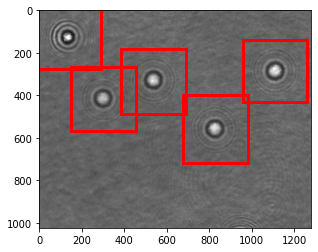

2
2
(1110.9813232421875, 284.99005126953125, 301.9932556152344, 295.5948486328125)
0
0
(138.29440307617188, 127.67613220214844, 301.5355224609375, 293.01666259765625)
After filtering:
                                              bboxes framenumber
0  (828.4598388671875, 557.8258666992188, 305.038...           5
1  (537.4846801757812, 333.4461364746094, 309.418...           5
2  (300.9446716308594, 416.3974304199219, 305.747...           5



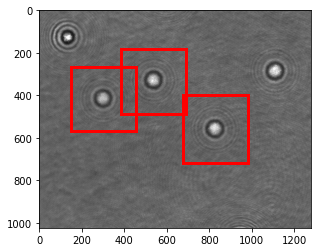

After cropping: 
          x_p         y_p    z_p  a_p  n_p  k_p    n_m  wavelength  \
0  828.459839  557.825867  100.0  1.0  1.5  0.0  1.335       0.532   
1  537.484680  333.446136  100.0  1.0  1.5  0.0  1.335       0.532   
2  300.944672  416.397430  100.0  1.0  1.5  0.0  1.335       0.532   

   magnification  alpha shape       model               coordinates  \
0          0.135    1.0  None  LMHologram  ((316, 316), (670, 400))   
1          0.135    1.0  None  LMHologram  ((309, 309), (383, 179))   
2          0.135    1.0  None  LMHologram  ((305, 305), (148, 264))   

                                              bboxes framenumber  
0  (828.4598388671875, 557.8258666992188, 305.038...           5  
1  (537.4846801757812, 333.4461364746094, 309.418...           5  
2  (300.9446716308594, 416.3974304199219, 305.747...           5  

After estimation:
          x_p         y_p         z_p       a_p       n_p  k_p    n_m  \
0  828.459839  557.825867  176.063324  0.821368  1.544789

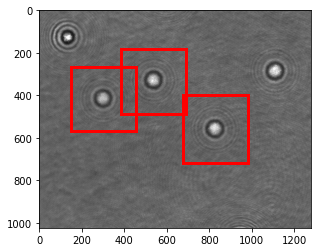

tload: 1.2736947536468506 | tloc: 128.22625350952148 | tcrop: 0.09269595146179199 | tfilt: 1.4908978939056396 | test: 1.7509419918060303 | twrite: 1.1814179420471191
Total time: 134.01704335212708


In [4]:
tload = 0
tloc = 0
tcrop = 0
tfilt = 0
test = 0
twrite = 0

t=[0]
def toggle(t=t):
    dt = time() - t[0]
    t[0] = time()
    return dt

t0 = time()
t[0]=time()

myvid = Video(path=video_path)     ## create Video object and set path
myvid.set_frames(framenumbers=list(range(6)))  ## set Frame paths for first 10 frames
for frame in myvid.frames:
    frame.load()                   ## read image from each file path
    tload += toggle()
    
    yolo = loc.predict(frame)
    print('YOLO predictions:')
    print(frame.to_df())
    print()
    frame.show()
    tloc += toggle()
    
    frame.no_edges()
    frame.nodoubles()
    print('After filtering:')
    print(frame.to_df())
    print()
    frame.show()
    tfilt += toggle()
    
    
    crop_frame(frame)
    print('After cropping: ')
    print(frame.to_df())
    print()
    est_imgs, est_scales, feats = est_crop_frame(frame, new_shape=est.pixels)
    tcrop += toggle()
    
    est.predict(est_imgs, est_scales, feats)
    print('After estimation:')
    print(frame.to_df())
    print()
    frame.show()
    
    test += toggle()
    
    frame.serialize(save=True)
    twrite += toggle()
    
    print('tload: {} | tloc: {} | tcrop: {} | tfilt: {} | test: {} | twrite: {}'.format(tload, tloc, tcrop, tfilt, test, twrite))
    toggle()
    

print('Total time: {}'.format(time()-t0))

Thus, using Frame and Video objects doesn't slow down the prediction process - the whole end-to-end procedure takes about the same amount of time.